## Estimating Residential Unit Price

Models used are:<br>
Decision Tree<br>
Random Forest<br>
Linear Model<br>
Support Vector Machine<br>

## Imorts

In [16]:
import os
import datetime
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import plotly.io as pio
import cufflinks as cf
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
mpl.rcParams.update({"axes.grid" : False, "grid.color": "black"})

pd.options.plotting.backend = 'plotly'

pio.templates.default = "plotly"
cf.go_offline()


## Data Importing and Preprocessing

In [17]:
df = pd.read_csv("bayut3.csv", thousands=',')
df = df[['beds', 'baths', 'area', 'location', 'price']].dropna(how='any')

df.beds = df.beds.str.split(' ', 1, expand=True)[0]
df.baths = df.baths.str.split(' ', 1, expand=True)[0]

area_unit =  df.area.str.split(' ', 1, expand=True)[1]
area =  df.area.str.split(' ', 1, expand=True)[0]

df['unit'] = area_unit
df.area = area.str.replace(',', '').astype(float)

c_area= []
for a, u in zip(df.area, df.unit):
    if u == 'sqft':
        c_area.append(a/10.764)
    else:
        c_area.append(a)

df.area = c_area
# df.to_csv('bayutTest2.csv')

studio_factor = 0.6
df = df.replace('Studio', studio_factor)
df.beds = df.beds.astype(float)
df.baths = df.baths.astype(float)

regions = []
for loc in df.location:
    region = loc.split(',')[-2]
    regions.append(str(region))
    
df['region'] = regions

df = df.drop(['location', 'unit'], axis=1)

In [18]:
df.region = df.region.map(lambda x: x[1:])

In [19]:
df.head()

,beds,baths,area,price,region
0,2.0,2.0,105.258268,1800000,The Lagoons
1,2.0,3.0,130.063174,1125000,Motor City
2,3.0,4.0,360.460795,3600000,Dubai Marina
4,0.6,1.0,34.838350,405000,Jumeirah Village Circle (JVC)
5,3.0,4.0,145.856559,2100000,Business Bay


In [20]:
known_categories = df.region.unique()
known_categories

array(['The Lagoons', 'Motor City', 'Dubai Marina',
       'Jumeirah Village Circle (JVC)', 'Business Bay',
       'Dubai Hills Estate', 'Serena', 'The Springs', 'Bluewaters Island',
       'Jumeirah Golf Estate', 'The Meadows', 'Palm Jumeirah',
       'The Views', 'Jumeirah Lake Towers (JLT)', 'Arabian Ranches',
       'Dubai Sports City', 'Emirates Hills', 'Arabian Ranches 2',
       'Mohammad Bin Rashid City', 'Al Warsan',
       'DAMAC Hills (Akoya by DAMAC)', 'Green Community',
       'Dubai Industrial Park', 'Jumeirah Village Triangle (JVT)',
       'Dubai Festival City', 'Dubai Silicon Oasis', 'Umm Suqeim',
       'Mudon', 'Remraam', 'Dubai Residence Complex', 'Wasl Gate',
       'Jumeirah Islands', 'Downtown Jebel Ali', 'Jumeirah',
       'Town Square', 'Old Town', 'Al Furjan', 'Dubai South', 'Dubailand',
       'Reem', 'The Greens', 'Arjan', 'Dubai World Central', 'Al Barari',
       'Jumeirah Beach Residence (JBR)', 'Discovery Gardens', 'The Lakes',
       'International City

## Correlation

In [21]:
df.corr(method='kendall')['price'].sort_values(ascending=False).to_frame().T

,price,area,beds,baths
price,1.0,0.720047,0.711074,0.665539


In [22]:
df.corr(method='spearman')['price'].sort_values(ascending=False).to_frame().T

,price,area,beds,baths
price,1.0,0.896362,0.85231,0.81324


In [23]:
df.corr(method='pearson')['price'].sort_values(ascending=False).to_frame().T

,price,beds,baths,area
price,1.0,0.549498,0.537223,0.454626


In [24]:
def one_hot_encoder(x):
    county_dummies = pd.get_dummies(x.region)
    df1 = pd.concat([x, county_dummies], axis=1)
    return df1.drop('region',axis=1)

df = one_hot_encoder(df)

## Modeling

In [25]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# scaled_df = pd.DataFrame(scaler.fit_transform(tabular_df), columns=tabular_df.columns)

x = df.drop('price', axis=1)

scale = True

if scale:
    x = pd.DataFrame(x_scaler.fit_transform(x), columns=x.columns)
    y = pd.DataFrame(y_scaler.fit_transform(df[['price']]), columns=['price'])
else:
    x = pd.DataFrame(x, columns=x.columns)
    y = pd.DataFrame(df[['price']], columns=['price'])

shuffle = True
train_size = int(len(x)*0.8)

if shuffle:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
else:
    x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

lr = LR()
dt = DT()
rf = RF()
svr = SVR()

models = [lr, dt, rf, svr]
models_names = ['Linear Model', 'Decision Tree', 'Random Forest', 'SVM']

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

metrics = ['mean_absolute_error', 'r2_score', 'mean_squared_error']

train_scores = {}
test_scores = {}
model_preds = {}

test_df = y_test.copy()
train_df = y_train.copy()

In [26]:
for model, model_name in zip(models, models_names):
    model.fit(x_train, y_train)
    
    test_df[model_name] = model.predict(x_test).flatten()
    train_df[model_name] = model.predict(x_train).flatten()

    train_scores[model_name] = []
    test_scores[model_name] = []
    
    for metric in metrics:
        train_scores[model_name].append(eval(metric)(train_df[model_name], y_train))
        test_scores[model_name].append(eval(metric)(test_df[model_name], y_test))
        
test_df.sort_index(inplace=True)
train_df.sort_index(inplace=True)

In [27]:
test_scores = pd.DataFrame(test_scores, index = metrics)
train_scores = pd.DataFrame(train_scores, index = metrics)

In [28]:
if scale:
    for c in test_df:
        test_df[c] = y_scaler.inverse_transform(test_df[[c]]).flatten()

    for c in train_df:
        train_df[c] = y_scaler.inverse_transform(train_df[[c]]).flatten()

## Results

In [29]:
train_scores

,Linear Model,Decision Tree,Random Forest,SVM
mean_absolute_error,0.015501,0.000560,0.002383,0.065164
r2_score,0.051074,0.997472,0.973153,-1.485606
mean_squared_error,0.001441,0.000007,0.000073,0.005073


In [30]:
test_scores

,Linear Model,Decision Tree,Random Forest,SVM
mean_absolute_error,0.016145,0.007767,0.006596,0.066182
r2_score,-0.068249,0.630617,0.734499,-1.448380
mean_squared_error,0.001570,0.001212,0.000753,0.005332


In [31]:
pct_error = test_df.copy()
for c in pct_error:
    pct_error[f'{c}_error'] = round(abs(pct_error[c] - pct_error['price'])/pct_error['price'] * 100, 2)
pct_error.drop('price_error', axis=1, inplace=True)

In [32]:
pct_error

,price,Linear Model,Decision Tree,Random Forest,SVM,Linear Model_error,Decision Tree_error,Random Forest_error,SVM_error
3,405000.0,-8.239902e+05,405000.0,3.999127e+05,7.265438e+06,303.45,0.00,1.26,1693.94
10,3199999.0,3.030665e+06,2290000.0,2.894514e+06,9.938052e+06,5.29,28.44,9.55,210.56
12,1875000.0,2.513645e+06,2000000.0,1.969515e+06,1.011555e+07,34.06,6.67,5.04,439.50
13,3370000.0,5.514825e+06,4285500.0,4.029500e+06,1.032589e+07,63.64,27.17,19.57,206.41
20,1600000.0,3.697967e+06,1690000.0,1.752590e+06,9.047146e+06,131.12,5.63,9.54,465.45
...,...,...,...,...,...,...,...,...,...
11740,5800000.0,2.549160e+06,5849999.0,3.303225e+06,8.832641e+06,56.05,0.86,43.05,52.29
11744,11000000.0,6.378394e+06,52000000.0,3.306395e+07,1.113519e+07,42.01,372.73,200.58,1.23
11748,450000.0,-1.522322e+06,389500.0,4.026273e+05,6.961724e+06,438.29,13.44,10.53,1447.05
11751,3499999.0,5.767167e+06,4460000.0,4.442551e+06,1.135363e+07,64.78,27.43,26.93,224.39


In [33]:
pct_error.mean().iloc[-4:]

Linear Model_error      97.613065
Decision Tree_error     18.648899
Random Forest_error     16.592402
SVM_error              639.552491
dtype: float64

In [34]:
forest_error = pct_error['Random Forest_error']
forest_error = pd.cut(forest_error, range(0, int(forest_error.max()+2), 10), right=True, ).value_counts()

## Actual vs Predicted

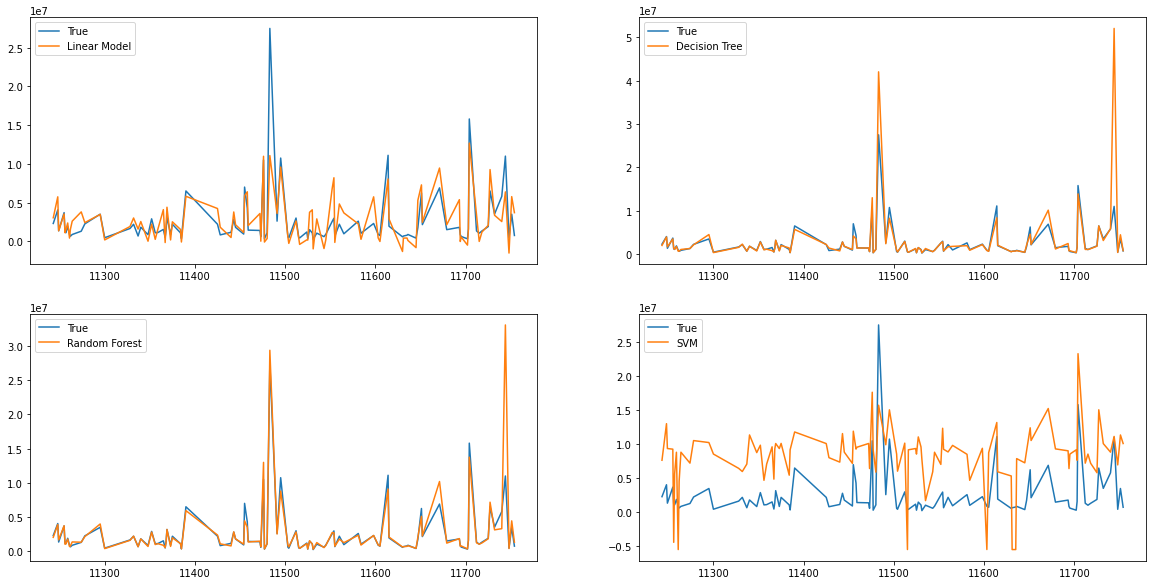

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(test_df['price'][-100:], label='True')
    ax.plot(test_df[i][-100:], label=i)
    ax.legend(loc='upper left')

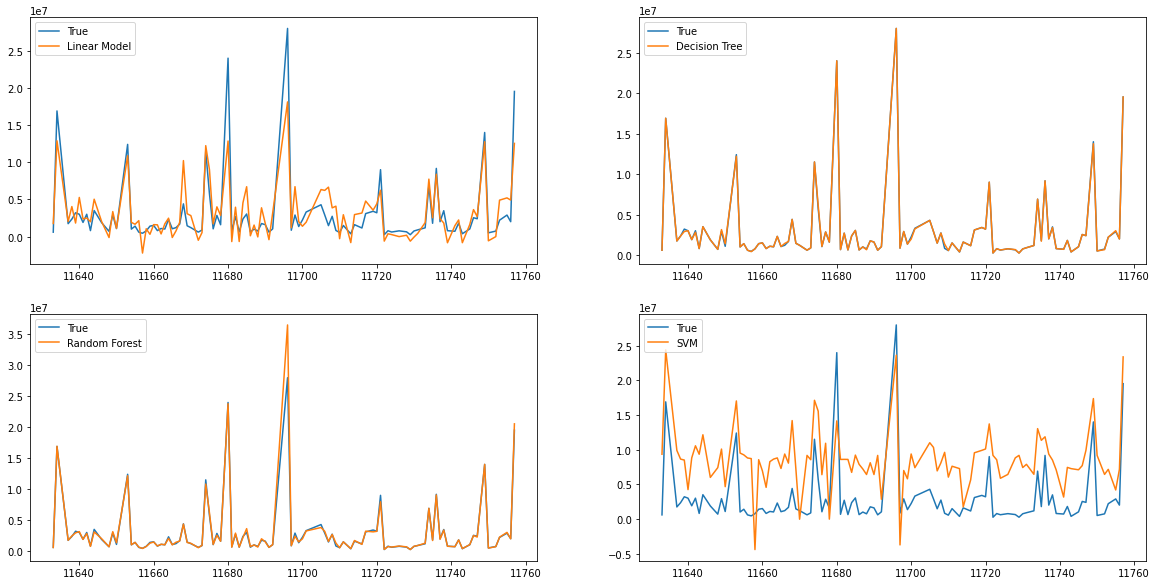

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(train_df['price'][-100:], label='True')
    ax.plot(train_df[i][-100:], label=i)
    ax.legend(loc='upper left')

## Saving

In [37]:
pipe = Pipeline([('scaler', x_scaler), ('forest', rf)])
to_save = {'pipe':pipe, 'y_scaler':y_scaler, 'regions':known_categories}
import pickle
f = open('inference.pickle', 'wb')
pickle.dump(to_save, f)

## Inferenece

In [38]:
import pickle
import pandas as pd
import numpy as np
import math
    
f = open('house_inference.pickle', 'rb')
dict_ = pickle.load(f)

def inference(beds, baths, area, location):


    location = pd.Categorical([location], categories = dict_['regions'])
    location_dummy = pd.get_dummies(location).values.flatten().tolist()

    test = np.array([beds, baths, area] + location_dummy).reshape(1, -1)

    pipe = dict_['pipe']
    price = int(dict_['y_scaler'].inverse_transform(pipe.predict(test).reshape(-1, 1)))

    return price

In [39]:
beds = 7
baths = 1
area = 50
location = 'Dubai Harbour'

price = inference(beds, baths, area, location)

price_len = len(str(price)) - 2

high = math.ceil(price / 10**price_len) * 10**price_len
low = math.floor(price / 10**price_len) * 10**price_len
price = f'{low:,} - {high:,} AED'

print(f'Estimated Unit Price is: {price}')

Estimated Car Price is: 590,000 - 600,000 AED
